# A brief analysis from the Data Science Portugal Meetup community

Data Science Portugal (DSPT) is an informal community of data science enthusiasts created with the purpose of sharing knowledge and experience in the fields of data science, machine learning and artificial intelligence. 
This is an attempt to explore characteristics about the community and to highlight its interests using publicly available data. 

### Building the dataset

We will start by collecting data from the official profile from Meetup (http://www.meetup.com/datascienceportugal). 
All the information used here is publicly available by any member using the Meetup API (https://www.meetup.com/meetup_api/). 


### Set up API Key
Setting up api keys.
In order to get your own Meetup developer key go to https://secure.meetup.com/meetup_api/key/ and insert bellow.

In [96]:
#personal meetup api key
meetup_api_key = "<insert-your-key>"

# Meetup id we are interested in
group_urlname = "datascienceportugal"

In [4]:
import requests
import json
import time
import codecs
import sys
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
# Will allow us to embed images in the notebook
%matplotlib inline

### Loading group information using Meetup REST API

This method loads information about DSPT's profile. 
We can fetch detailed info such as number of members, description, organizers and next scheduled events.

In [5]:
meetup_api = "https://api.meetup.com/"

def load_group_info(groupname):    
    request = requests.get( meetup_api + groupname, params={"key":meetup_api_key})
    meetup_data = request.json()
    return meetup_data
    
group_info = load_group_info(group_urlname)


print(group_info["name"])
print(group_info["members"])
print(group_info["link"])
print(group_info["next_event"])

print()
print("All information we can collect ...")
print(group_info.keys())


Data Science Portugal (DSPT)
756
https://www.meetup.com/datascienceportugal/
{'id': '244995385', 'name': 'DSPT#18 - The Big Data Championship', 'yes_rsvp_count': 33, 'time': 1511375400000, 'utc_offset': 0}

All information we can collect ...
dict_keys(['id', 'name', 'status', 'link', 'urlname', 'description', 'created', 'city', 'country', 'localized_country_name', 'localized_location', 'state', 'join_mode', 'visibility', 'lat', 'lon', 'members', 'organizer', 'who', 'key_photo', 'timezone', 'next_event', 'category', 'meta_category'])


### Detailed DSPT profile description 

In [6]:
display(HTML(group_info["description"]))

### Load members profiles

Now what really matter are is profile information from each DSPT member. 
The following code paginates over the api to collect info from every single member.

In [7]:
def load_more_meetup_data(url):
    request = requests.get(url)
    data = request.json()
    
    members = data["results"]

    if("next" in data["meta"].keys()):
        if(data["meta"]["next"] is not ""):
            print("fetching page ... ")
            members = members + load_more_meetup_data(data["meta"]["next"])
            
    return members
            
def load_members_from_group(group_urlname):
    url = "https://api.meetup.com/2/members"

    request = requests.get(url,params={"offset":0,
                                       "format":"json",
                                       "key":meetup_api_key,
                                       "group_urlname":group_urlname})
    
    data = request.json()
    members = data["results"]
    
    if(data["meta"]["next"] is not ""):
        print("fetching page ... ")
        members = members + load_more_meetup_data(data["meta"]["next"])
    
    return members
    
print("fetching members...")    
members = load_members_from_group(group_info["urlname"])

print("members fetched ", len(members))

fetching members...
fetching page ... 
fetching page ... 
fetching page ... 
members fetched  756


### Convert data to pandas DataFrame

To make things easier lets convert the data structure into a pandas.DataFrame and see a sample of the dataset.

In [8]:
df = pd.DataFrame(members)

# persist dataset
df.to_csv("members.csv")

df.head() 

,bio,city,country,hometown,id,joined,lang,lat,link,lon,name,other_services,photo,self,state,status,topics,visited
0,NaN,Porto,pt,NaN,89159812,1487062197000,NaN,41.15,http://www.meetup.com/members/89159812,-8.62,Adal,{},{'highres_link': 'https://secure.meetupstatic....,{'common': {}},NaN,active,"[{'urlkey': 'webstandards', 'name': 'Web Stand...",1510353139000
1,NaN,Porto,pt,NaN,227309981,1494436558000,NaN,41.15,http://www.meetup.com/members/227309981,-8.62,Afonso Silva,{},{'highres_link': 'https://secure.meetupstatic....,{'common': {}},NaN,active,"[{'urlkey': 'knowledge-sharing', 'name': 'Know...",1510323708000
2,NaN,Porto,pt,NaN,240136574,1509441928000,NaN,41.15,http://www.meetup.com/members/240136574,-8.62,Ahmed Fares,{},{'highres_link': 'https://secure.meetupstatic....,{'common': {}},NaN,active,[],1509441928000
3,NaN,Khadki,in,NaN,223975793,1509726808000,NaN,18.57,http://www.meetup.com/members/223975793,73.83,Akshay Kant,{},{'highres_link': 'https://secure.meetupstatic....,{'common': {}},NaN,active,"[{'urlkey': 'newtech', 'name': 'New Technology...",1510321853000
4,NaN,Aveiro,pt,Aveiro,220719554,1486507470000,NaN,40.65,http://www.meetup.com/members/220719554,-8.66,Alberto São Marcos,{'twitter': {'identifier': '@albertocsm'}},{'highres_link': 'https://secure.meetupstatic....,{'common': {}},NaN,active,[],1496329142000


## Portuguese meetup, international community

Users can provide information about where they live and their hometown. 
Most of the members live in Porto, followed by Lisbon, Aveiro, Braga and Coimbra. 

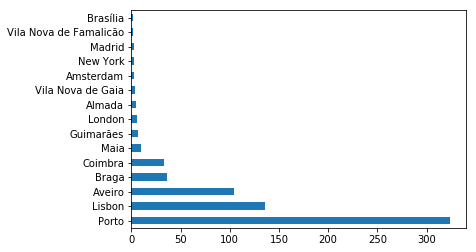

In [9]:
top_cities = df['city'].value_counts()[:15]
top_cities.plot(kind='barh')

Some users provided their hometown as well. 
We can see that we have quite an international community with people from countries like Brazil, UK, Italy, USA and Ireland.

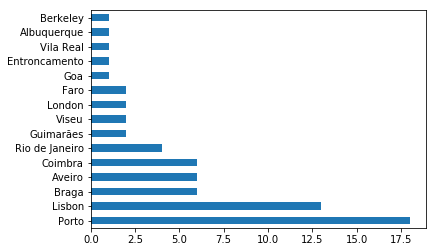

In [10]:
# this method is here just fixing bad input values. 
# people tend to inform hometown and country all together. 
def fix_hometown_values(x):
    if(type(x) is str):
        x = x.replace(",","-")
        x = x.split("-")[0]
        x = x.strip()
    return x

df['hometown'] = df['hometown'].apply(lambda x: fix_hometown_values(x) )
top_cities = df['hometown'].value_counts()[:15]
top_cities.plot(kind='barh')

## Common interests

Users can also provide their interests in their profiles. Things that they see as their goal attending meetups.
Here we plot the most frequent among them. 

In [110]:
all_topics = []

def flat_topics(row):
#     print(row)
    topics = [x["name"] for x in row]
    for topic in topics:
        all_topics.append(topic)

df["flat_topics"] = df["topics"].apply(lambda x: flat_topics(x))

# printing the top 15 most mentioned interests
from collections import Counter
Counter(all_topics).most_common(15)

[('New Technology', 252),
 ('Startup Businesses', 142),
 ('Open Source', 137),
 ('Education & Technology', 122),
 ('Software Development', 113),
 ('Data Analytics', 109),
 ('Machine Learning', 109),
 ('Innovation', 108),
 ('Web Technology', 100),
 ('Technology Startups', 98),
 ('Computer programming', 97),
 ('Big Data', 90),
 ('Lean Startup', 82),
 ('Cloud Computing', 82),
 ('Predictive Analytics', 76)]

### Plotting common interests as a Wordcloud

There is always a sexier way to plot words :)

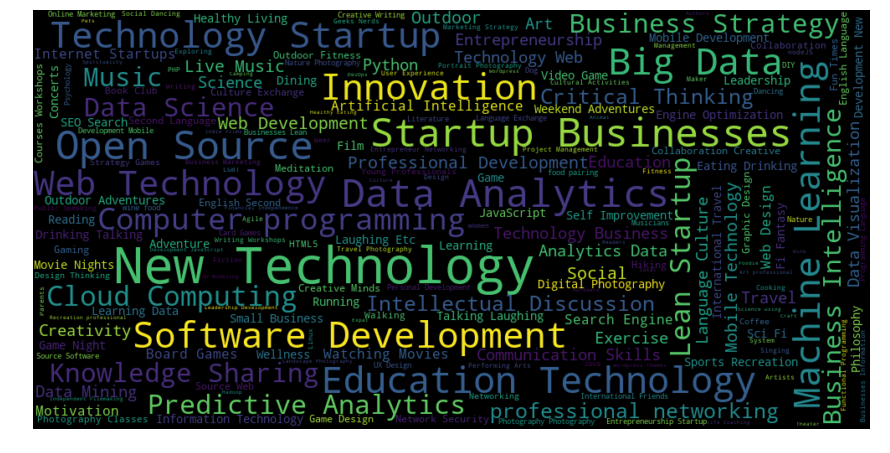

In [111]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=500, max_font_size=60).generate(", ".join(all_topics))

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Membership growth

The meetup is continually attracting new audience, specially during the last quarter of 2017.

In [184]:
def plot_timeline(field_name,plot_title):
    # convert joined date to datetime and drop hours
    date_field = field_name + "_dt"
    df[date_field] = pd.to_datetime(df[field_name]*1000000)
    df[date_field] = df[date_field].apply(lambda x : x.date())

    # group by date and aggregate
    grouped_dates = df.groupby(df[date_field])
    grouped_dates_count = grouped_dates[date_field].aggregate(len)

    # create datetime series ranging from first date to the last one
    idx = pd.date_range(min(df[date_field]), max(df[date_field]))
    s = grouped_dates_count

    # filling missing dates with zero
    s.index = pd.DatetimeIndex(s.index)
    s = s.reindex(idx, fill_value=0)

    # plot
    plt.figure(figsize=(15, 3))
    plt.title(plot_title)
    plt.xticks(rotation=90)
    plt.plot(s)

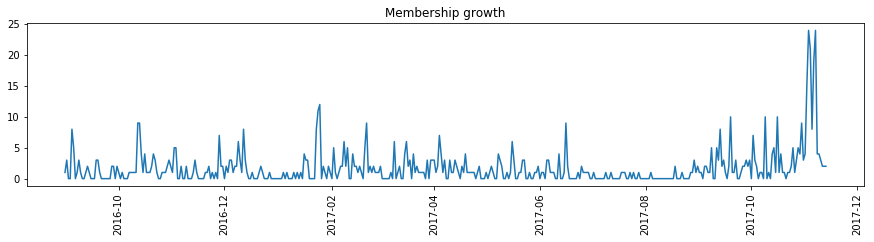

In [183]:
plot_timeline("joined","Membership growth")    

### Last time people checked the DSPT Meetup website profile

This last timeseries illustrates that the majority of the community is up to date about the meetings informations and calls.

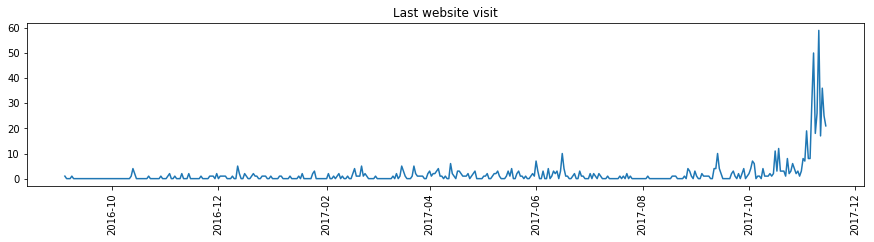

In [188]:
plot_timeline("visited","Last website visit")

### BONUS: Visualizing members around the world

If you are running this notebook in your local jupyter environment you can install a special widget to plot maps inline.

A better representation to illustrate how members are spread around the world. 
The majority is in Portugal, naturally, but it is curious to see people from far away interested in our meetups. 

First, lets convert geo location information to geojson format.

In [105]:
import geojson

def data2geojson(df):
    features = []
    df.apply(lambda X: features.append( 
            geojson.Feature(geometry=geojson.Point((X["lon"], 
                                                    X["lat"])), 
                            properties=dict(name=X["city"])))
                            , axis=1)
    
    with open('map.geojson', 'w') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True)
        
geo_df = df[['city','lon','lat']]

print(geo_df.head())

geojson = data2geojson(geo_df)

     city    lon    lat
0   Porto  -8.62  41.15
1   Porto  -8.62  41.15
2   Porto  -8.62  41.15
3  Khadki  73.83  18.57
4  Aveiro  -8.66  40.65


### Plotting geo location information 
 
If you are running this notebook locally you can enable map visualization inline .
In order to enable this widget you need to follow these steps:

Using pip:

> $ pip install ipyleaflet

> $ jupyter nbextension enable --py --sys-prefix ipyleaflet

more details: https://github.com/ellisonbg/ipyleaflet

In [106]:
from __future__ import print_function
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

center = [0, 0]
zoom = 2

m = Map(center=center, zoom=zoom)
display(m)

A Jupyter Widget

In [107]:
import matplotlib as mpl
import matplotlib.cm
import matplotlib.colors
import numpy as np

import json
with open('map.geojson') as f:
    data = json.load(f)
    
n_features = len(data['features'])
print("plotting data points",n_features)

g = GeoJSON(data=data)
m.add_layer(g)

plotting data points 756
